In [57]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import gc
from tqdm.notebook import trange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2DTranspose, 
                                     SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from keras.callbacks import CSVLogger
K.clear_session()
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline

In [32]:
#Parameters
w, h = 256,256
border = 5     

ids = next(os.walk("SegTMS/train/"))[1] 
print("No. of folder = ", len(ids))

No. of folder =  2


In [33]:
#Load data
train = sorted(glob.glob("SegTMS/train/Images/*"))
train_mask = sorted(glob.glob("SegTMS/train/Labels/*.png"))#[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')     


Total Train Images : 200
Total Mask Image : 200


In [34]:
#data processing

X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)
     

for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
    # Load images
    img = load_img(img)
    x_img = img_to_array(img)
    x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
    # # Load masks
    mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
    mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
    # # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
     


0it [00:00, ?it/s]

In [43]:
# Save as in Numpy array
np.save('SegTMS/XandY/X.npy', X)
np.save('SegTMS/XandY/y.npy', y)
# print(X.shape, y.shape)

X = np.load('SegTMS/XandY/X.npy')
y = np.load('SegTMS/XandY/y.npy')
print(X.shape, y.shape)

(200, 256, 256, 3) (200, 256, 256, 1)


In [44]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(180, 256, 256, 3) (180, 256, 256, 1) (20, 256, 256, 3) (20, 256, 256, 1)


6868

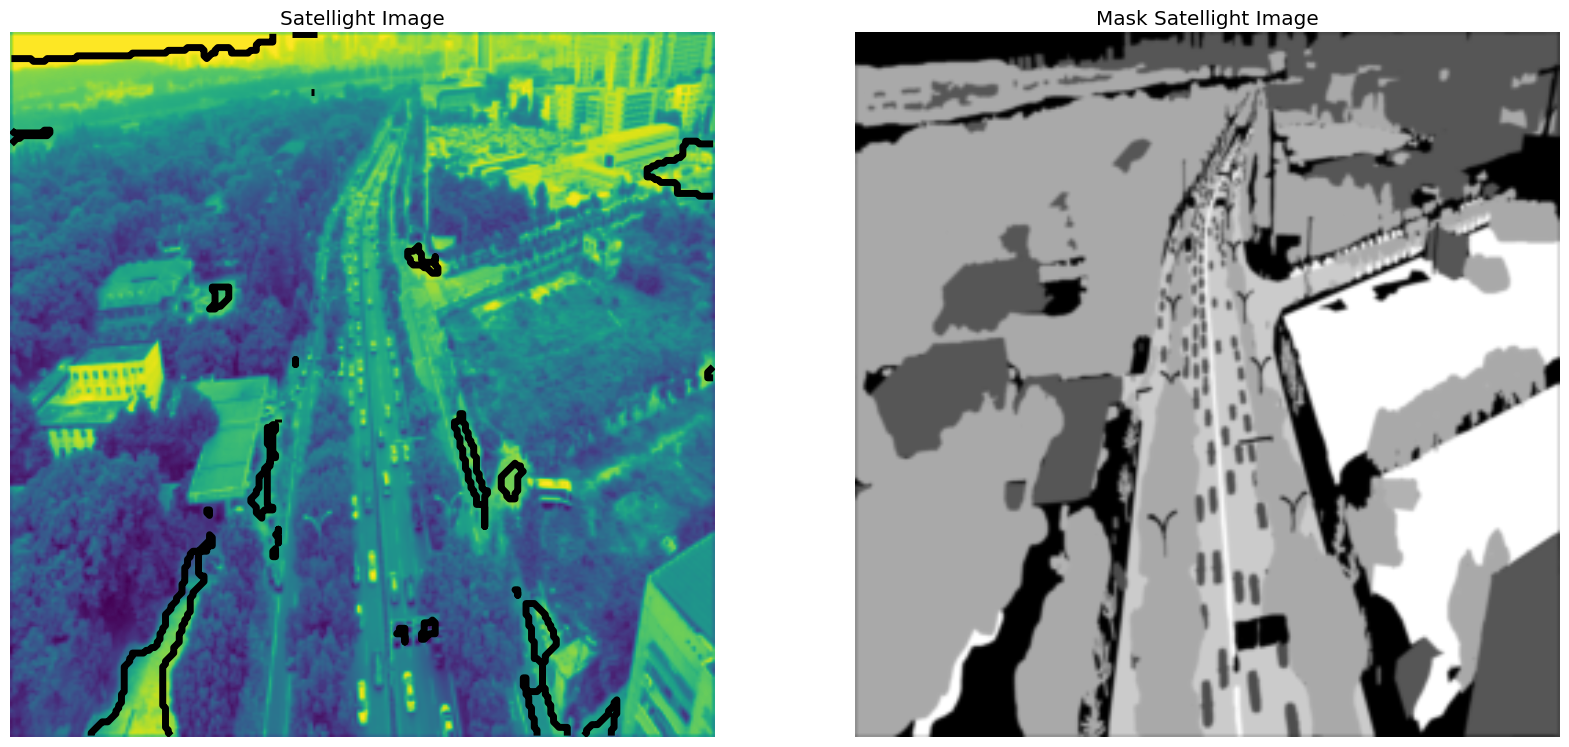

In [96]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')

if has_mask: 
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()


In [97]:
#valid tensor gen
nbatch=8
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(nbatch)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(nbatch)

In [98]:
#unet layes
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [99]:
# UNET Model 

def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
     


In [100]:
#model set

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()    


111141

In [101]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                                                  
 dropout_5 (Dropout)            (None, 64, 64, 128)  0           ['concatenate_1[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 64)   73792       ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 64)  256         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_tr

In [102]:
callbacks = [
    EarlyStopping(patience=100, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=25, min_lr=0.00001, verbose=1),
    ModelCheckpoint('modelUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv")]  


In [103]:
nepochs=50
results = model.fit(X_train, y_train, batch_size=nbatch, epochs=nepochs, callbacks=callbacks,
                    validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.0943 - auc: 0.5573 - sensitivity_at_specificity: 0.5646 - specificity_at_sensitivity: 0.5814
Epoch 1: val_loss improved from inf to 0.57584, saving model to modelUnet.h5
23/23 [==============================] - 58s 2s/step - loss: 0.5761 - accuracy: 0.0943 - auc: 0.5573 - sensitivity_at_specificity: 0.5646 - specificity_at_sensitivity: 0.5814 - val_loss: 0.5758 - val_accuracy: 0.1041 - val_auc: 0.5738 - val_sensitivity_at_specificity: 0.5957 - val_specificity_at_sensitivity: 0.5839 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.0992 - auc: 0.5805 - sensitivity_at_specificity: 0.5955 - specificity_at_sensitivity: 0.5847
Epoch 2: val_loss did not improve from 0.57584
23/23 [==============================] - 63s 3s/step - loss: 0.5382 - accuracy: 0.0992 - auc: 0.5805 - sensitivity_at_specificity: 0.5955 - specificity_at_sensitivity: 0.5847 - val_l

23/23 [==============================] - 61s 3s/step - loss: 0.5227 - accuracy: 0.0993 - auc: 0.7167 - sensitivity_at_specificity: 0.8020 - specificity_at_sensitivity: 0.7707 - val_loss: 0.5424 - val_accuracy: 0.1043 - val_auc: 0.6359 - val_sensitivity_at_specificity: 0.6613 - val_specificity_at_sensitivity: 0.6425 - lr: 0.0010
Epoch 16/50
23/23 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.0993 - auc: 0.7068 - sensitivity_at_specificity: 0.7854 - specificity_at_sensitivity: 0.7586
Epoch 16: val_loss improved from 0.54085 to 0.53735, saving model to modelUnet.h5
23/23 [==============================] - 61s 3s/step - loss: 0.5224 - accuracy: 0.0993 - auc: 0.7068 - sensitivity_at_specificity: 0.7854 - specificity_at_sensitivity: 0.7586 - val_loss: 0.5373 - val_accuracy: 0.1043 - val_auc: 0.6413 - val_sensitivity_at_specificity: 0.6904 - val_specificity_at_sensitivity: 0.6846 - lr: 0.0010
Epoch 17/50
23/23 [==============================] - ETA: 0s - loss: 0.5211

Epoch 30/50
23/23 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.0993 - auc: 0.8195 - sensitivity_at_specificity: 0.9373 - specificity_at_sensitivity: 0.8684
Epoch 30: val_loss did not improve from 0.53297
23/23 [==============================] - 55s 2s/step - loss: 0.5123 - accuracy: 0.0993 - auc: 0.8195 - sensitivity_at_specificity: 0.9373 - specificity_at_sensitivity: 0.8684 - val_loss: 0.5337 - val_accuracy: 0.1043 - val_auc: 0.6769 - val_sensitivity_at_specificity: 0.7557 - val_specificity_at_sensitivity: 0.7142 - lr: 0.0010
Epoch 31/50
23/23 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.0993 - auc: 0.8269 - sensitivity_at_specificity: 0.9397 - specificity_at_sensitivity: 0.8773
Epoch 31: val_loss improved from 0.53297 to 0.53197, saving model to modelUnet.h5
23/23 [==============================] - 59s 3s/step - loss: 0.5127 - accuracy: 0.0993 - auc: 0.8269 - sensitivity_at_specificity: 0.9397 - specificity_at_sensitivity: 0.8773

Epoch 45/50
23/23 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.0993 - auc: 0.8851 - sensitivity_at_specificity: 0.9755 - specificity_at_sensitivity: 0.9301
Epoch 45: val_loss did not improve from 0.53143
23/23 [==============================] - 95s 4s/step - loss: 0.5047 - accuracy: 0.0993 - auc: 0.8851 - sensitivity_at_specificity: 0.9755 - specificity_at_sensitivity: 0.9301 - val_loss: 0.5464 - val_accuracy: 0.1043 - val_auc: 0.6704 - val_sensitivity_at_specificity: 0.7829 - val_specificity_at_sensitivity: 0.6822 - lr: 0.0010
Epoch 46/50
23/23 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.0993 - auc: 0.8790 - sensitivity_at_specificity: 0.9760 - specificity_at_sensitivity: 0.9209
Epoch 46: val_loss did not improve from 0.53143
23/23 [==============================] - 105s 5s/step - loss: 0.5056 - accuracy: 0.0993 - auc: 0.8790 - sensitivity_at_specificity: 0.9760 - specificity_at_sensitivity: 0.9209 - val_loss: 0.5353 - val_accurac

In [104]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result   


,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
43,0.505813,0.099275,0.880613,0.974629,0.926088,0.531429,0.104318,0.686730,0.762316,0.698754,0.001
30,0.512684,0.099275,0.826924,0.939680,0.877308,0.531973,0.104318,0.660781,0.722588,0.687074,0.001
24,0.516801,0.099275,0.779602,0.898192,0.811812,0.532972,0.104318,0.624670,0.675676,0.620477,0.001
29,0.512316,0.099275,0.819490,0.937263,0.868412,0.533701,0.104318,0.676883,0.755733,0.714215,0.001
49,0.502814,0.099275,0.902224,0.982565,0.942259,0.533783,0.104318,0.674945,0.748738,0.682042,0.001
37,0.508390,0.099275,0.861430,0.966408,0.905786,0.534636,0.104318,0.635410,0.708295,0.659502,0.001
48,0.504315,0.099275,0.883708,0.981706,0.922789,0.534885,0.104318,0.690682,0.781730,0.721397,0.001
45,0.505569,0.099275,0.878976,0.975986,0.920929,0.535346,0.104318,0.673713,0.767804,0.682620,0.001
17,0.521577,0.099275,0.735004,0.809803,0.782591,0.535386,0.104318,0.666900,0.740100,0.696721,0.001
34,0.508824,0.099275,0.845128,0.958470,0.888208,0.535387,0.104318,0.668653,0.755180,0.694534,0.001


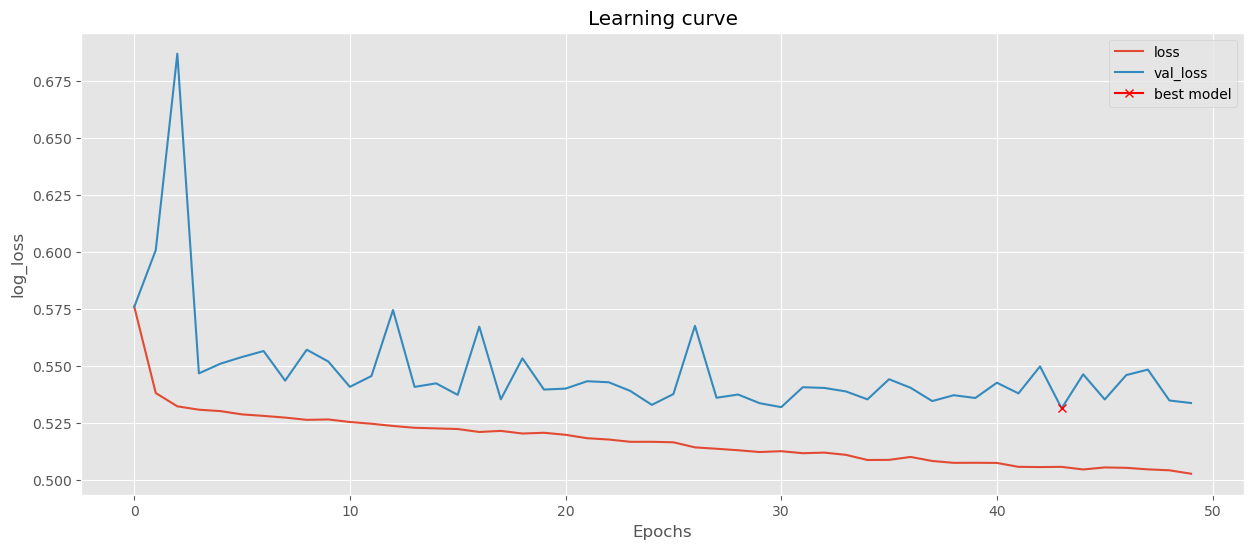

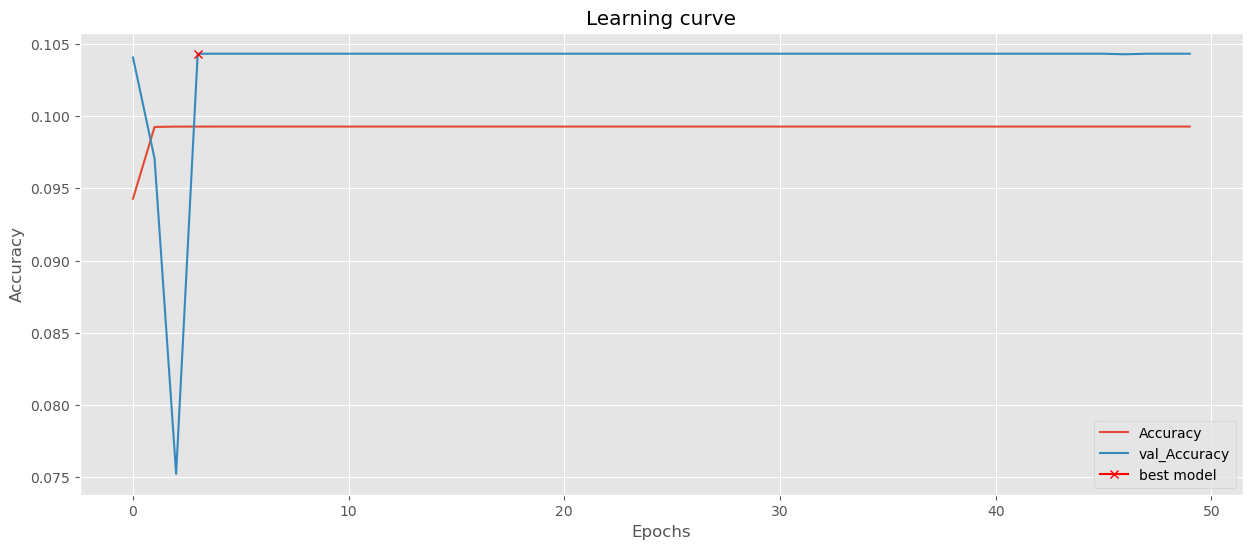

In [105]:
#plot performances
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
#-------------
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [106]:
model.load_weights('modelUnet.h5')

model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.5314 - accuracy: 0.1043 - auc: 0.6867 - sensitivity_at_specificity: 0.7623 - specificity_at_sensitivity: 0.6988


[0.5314286947250366,
 0.10431823879480362,
 0.6867296695709229,
 0.7623161673545837,
 0.6987537741661072]

In [107]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 1s 1s/step


In [108]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [109]:
# plot results

def plot_sample(X, y, preds, binary_preds, ix=None):

    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow((X[ix, ..., 0]), cmap='brg')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    
    plt.show()
     


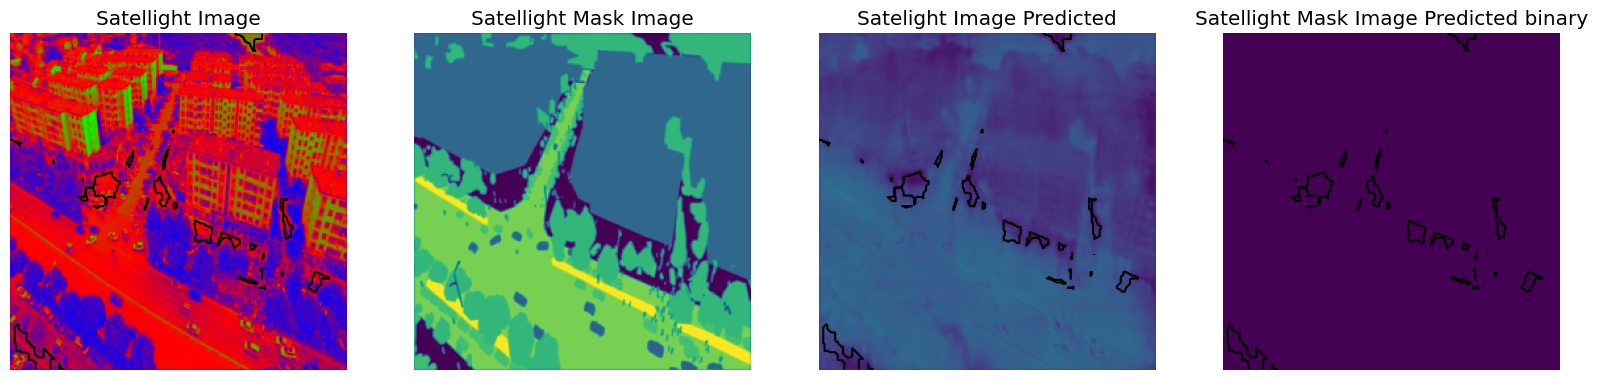

In [110]:
#Predictions on training set
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=5)

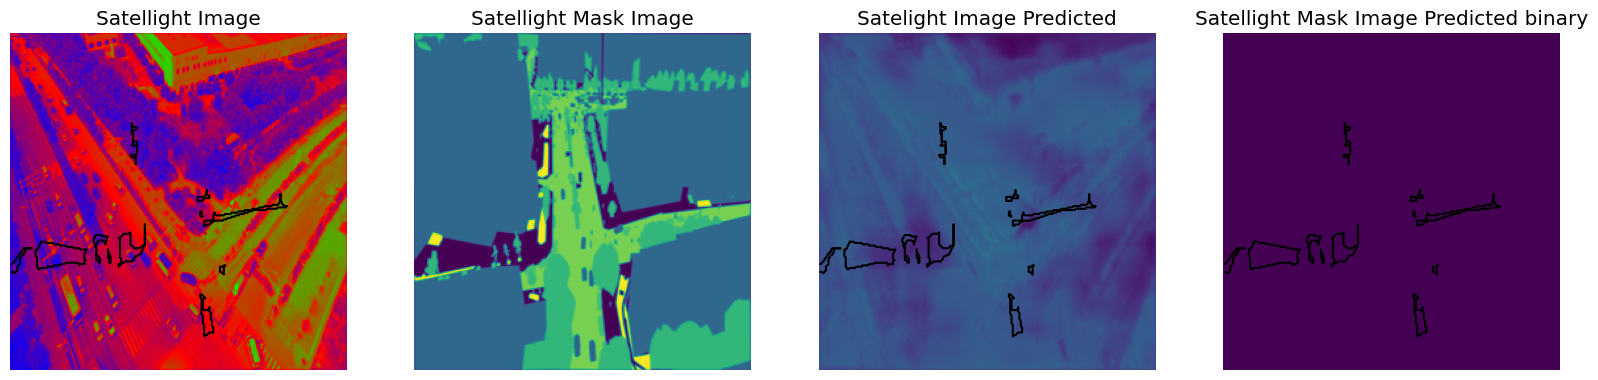

In [111]:
#Predictions on training set
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=10)

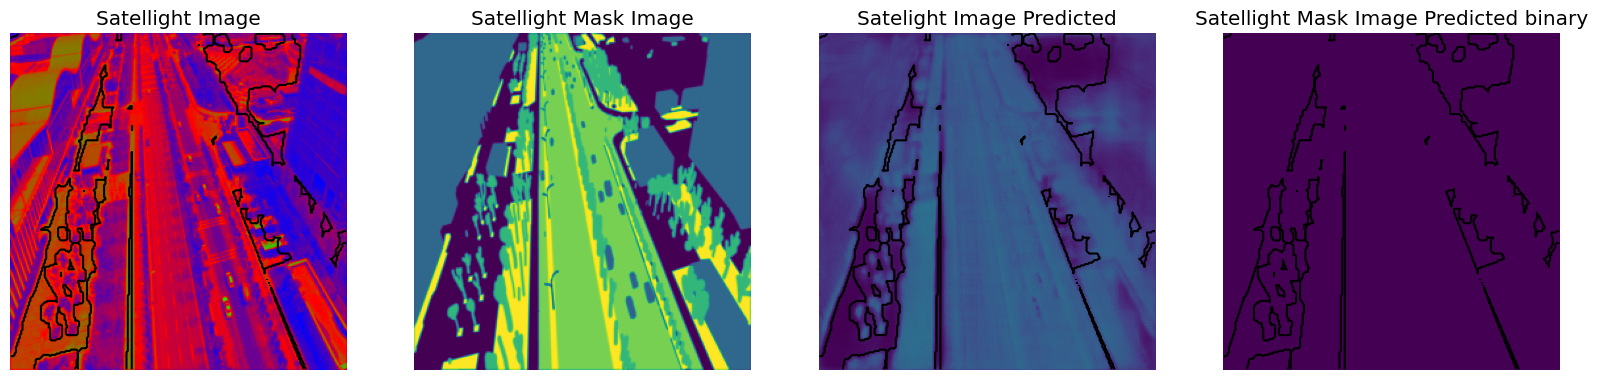

In [112]:
#Predictions on training set
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=15)

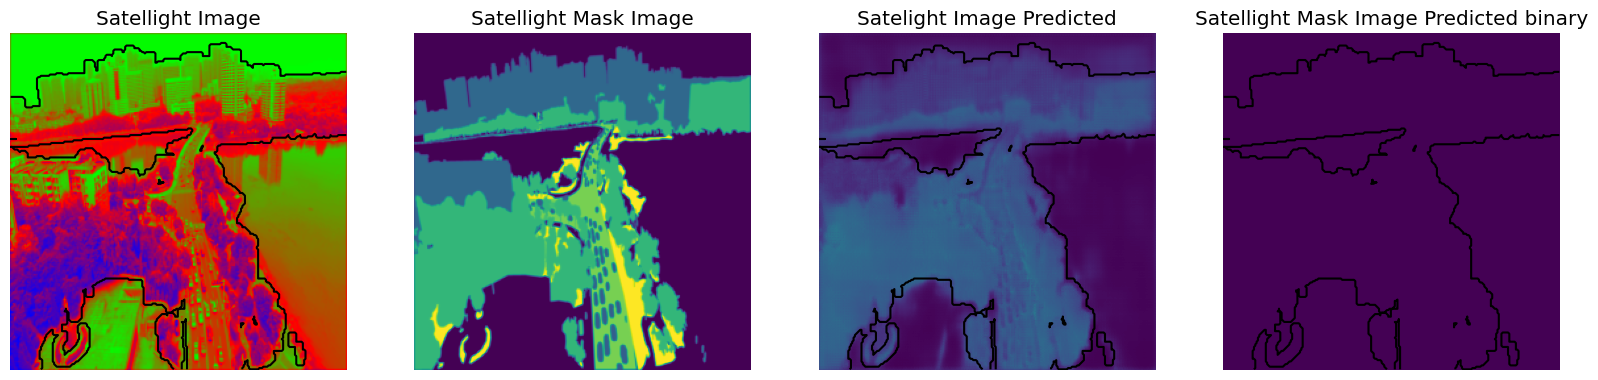

In [113]:
#Predictions on training set
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=20)

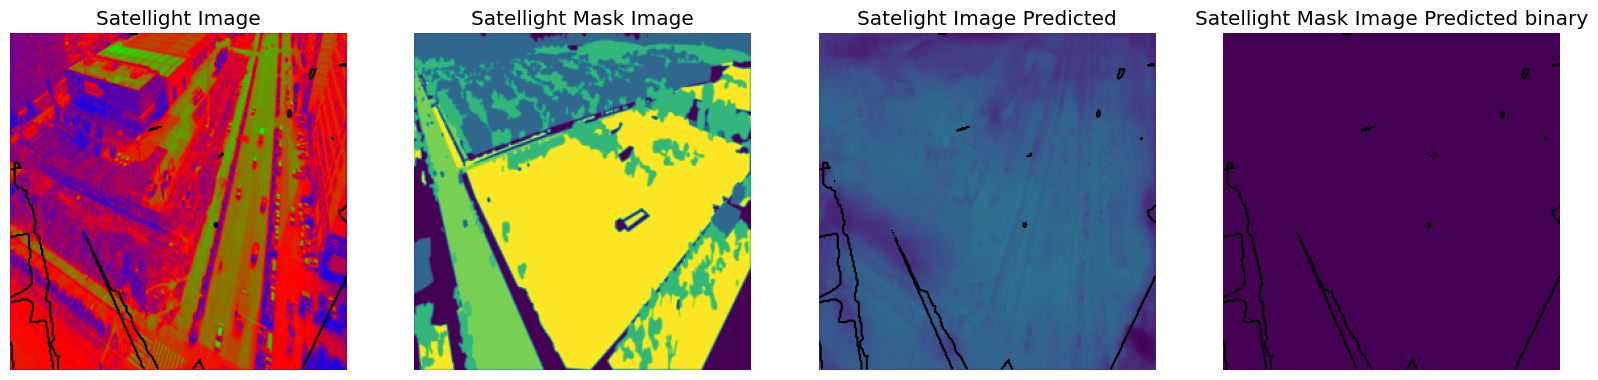

In [114]:
#Predictions on training set
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=25)